# Glutamine Synthetase Inhibition through End Products of Glutamine Metabolism

### BME 3990 Final Project by Eamon, Julia, and Shannon

This notebook uses the CSB2 environment and will be incorporating code from previous notebooks in this class. 

### Introduction:

Glutamine is an amino acid primarily used in protein biosynthesis. Glutamine is heavily involved in cell metabolism, supplementing the citric acid cycle and serving as a precursor to several nonessential amino acids, nucleotides, and other important biomolecules. The enzyme glutamine synthetase catalyzes the condensation of glutamate and ammonia to form glutamine. Glutamine synthetase is regulated through end product inhibition by nine end products of glutamine that allosterically bind to different sites on the enzyme to almost entirely inhibit activity. Our project aims to investigate the mechanisms of end product regulation of glutamine synthetase while incorporating Michaelis-Menten kinetics of glutamine synthetase to gain a larger scope of the synthesis of glutamine with glutamine synthetase. We plan to initially explore the nine inhibitor constants (Ki) and how they contribute to the overall inhibition of glutamine synthetase activity. We will investigate the specific mechanism through which the nine end products of glutamine inhibit glutamine synthesis. We will look for patterns and combine our insights into end product regulation with Michaelis-Menten kinetics to form a comprehensive understanding of glutamine synthetase activity. Lastly, we will examine how the presence of inhibitors influences substrate binding and catalytic turnover rates. 


In [34]:
#Imports  
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [35]:
#Modeling Michaelis-Menten kinetics for Glutamine Synthetase
#Initial constants
K_cat = 2580
K_M = 3
#Variables
E_0 = 10e-3
#Range of reactant concentrations
A = np.linspace(0,1000,1000)
#Calculate rate from MM equation
v = K_cat*E_0*(A/(K_M+A))
V_max = K_cat * E_0

Text(0.5, 1.0, 'Michaelis Menten Kinetics - GLutamine Synthetase')

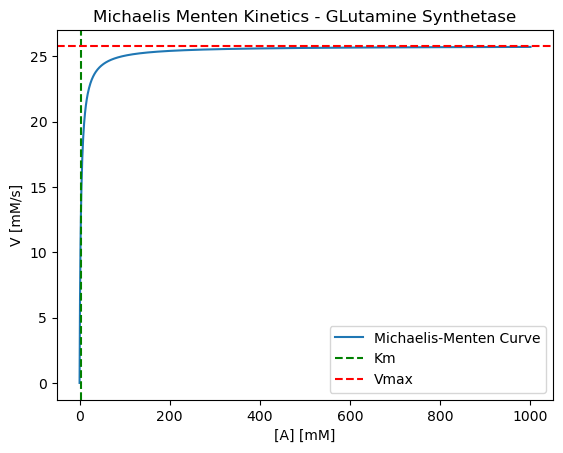

In [36]:
#Plot V vs A
plt.plot(A,v,label ='Michaelis-Menten Curve')
plt.xlabel('[A] [mM]')
plt.ylabel('V [mM/s]')
#Plot Km 
plt.axvline(x =K_M, color ='g',linestyle ='--',label='Km')
plt.axhline(y = V_max, color ='r',linestyle ='--',label='Vmax')
plt.legend()
plt.title('Michaelis Menten Kinetics - GLutamine Synthetase')

In [37]:
#Constants
K_cat = 2580
K_M = 30
#Variables
E_0 = 10e-3
#ODE
def MM_dynamics(t,y,K_cat,K_M,E_0):
    # y[0] = B product
    # y[1] = A reactant
    dydt = np.zeros(2)
    v = K_cat*E_0*(y[1]/(K_M+y[1]))
    dydt[0] = v
    dydt[1] = -v
    return dydt

In [38]:
#Initial Conditions
y0 = [0,100]
# time span
t = np.linspace(0,10,100)
tspan = [t[0],t[-1]]

ode_sol = solve_ivp(lambda t,y:MM_dynamics(t,y,K_cat,K_M,E_0),tspan,y0,t_eval=t)

Text(0.5, 1.0, 'mM vs time - Glutamine Synthetase')

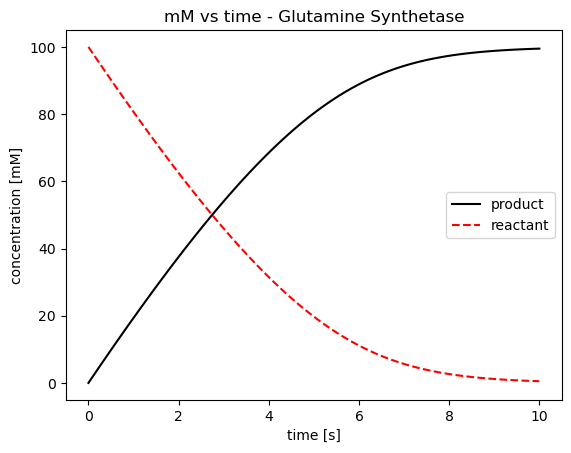

In [39]:
#Plot results
plt.plot(t,ode_sol.y[0],'k-')
plt.plot(t,ode_sol.y[1],'r--')
plt.xlabel('time [s]')
plt.ylabel('concentration [mM]')
plt.legend(['product','reactant'])
plt.title('mM vs time - Glutamine Synthetase')

In [ ]:
#Define parameters for inhibitors




In [ ]:
#plot all inhibitors in a subplot
[fig,axs] = plt.subplots(2,4,figsize=[12,8])
